# **Table of Content**

0. **Task Overview**

1. **Time Series Interactive Plot** 

2. **Exploration** : Pre e post Covid, seasonality, Stationarity

3. **Modelling**
   - Benchmark models: average e seasonal average models
   - ARIMA
   - Exogenous Regression approach
   - Exogenous ARIMA
   - Exogenous SARIMA
   - Holt Winters ES


4. **Conclusions**

### **Task Overview**
  
The attached file contains the list of user registrations for an online service.  
Your task is to build a forecast model that predicts user registration growth, forecasting until the end of 2022.   
**Vaiables description**:

**"Date":** 
- Date of registration.  
- Date available: 2017-01-11 - 2021-05-31
- Prediction needed for whole 2022  

**"Users":** 
- Number of users registered. 
- integer from 0 to 109

**"Lockdown_flag":** 
- Indicates periods of lockdown.  
- Values 0,1  

**"Campaigns_flag":** 
- Highlights key campaigns sent out.  
- Values 0,1  

In [262]:
import warnings
warnings.filterwarnings('ignore')

In [283]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from scipy.stats import ttest_ind
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [264]:
# commands for print in bold
start_bold = str('\033[1m')
end_bold = str("\033[0m")


# import data
data_path = r"C:\Users\Utente\OneDrive\Desktop\Boston Scientific\Boston Scientific - Data Scientist - Task.xlsx"
data = pd.read_excel(data_path )

# change weekday language
italian_to_english = {
    'Lunedì': 'Monday',
    'Martedì': 'Tuesday',
    'Mercoledì': 'Wednesday',
    'Giovedì': 'Thursday',
    'Venerdì': 'Friday',
    'Sabato': 'Saturday',
    'Domenica': 'Sunday'
}

# Conversione dei nomi dei giorni della settimana
data['Weekday'] = data['Weekday'].map(italian_to_english)


# show data table structure
print(start_bold + "Data table: \n" + end_bold , data.head(7))
print()
print(start_bold + "Data types: \n" + end_bold ,data.dtypes )

# set date as index
data.set_index('Date', inplace=True)

print()
print(start_bold + "NOTE" + end_bold + "--> Column Date set as the index of the time series")
print(start_bold + "NOTE" + end_bold + "--> For lather analysis on excel the data file was modified adding the days of the week name")


Data table: 
         Date  Users  Lockdown_flag  Campaigns_flag    Weekday
0 2017-01-11      1              0               0  Wednesday
1 2017-01-12      1              0               0   Thursday
2 2017-01-13      1              0               0     Friday
3 2017-01-14      1              0               0   Saturday
4 2017-01-15      3              0               0     Sunday
5 2017-01-16      1              0               0     Monday
6 2017-01-17      1              0               0    Tuesday

Data types: 
 Date              datetime64[ns]
Users                      int64
Lockdown_flag              int64
Campaigns_flag             int64
Weekday                   object
dtype: object

NOTE--> Column Date set as the index of the time series
NOTE--> For lather analysis on excel the data file was modified adding the days of the week name


## **1. Time series interactive plot**

We first plot the data, showing the first lockdown and commercial campaign dates (respectively red and green line).  
We immediately notice that the series changes behavior after these dates 

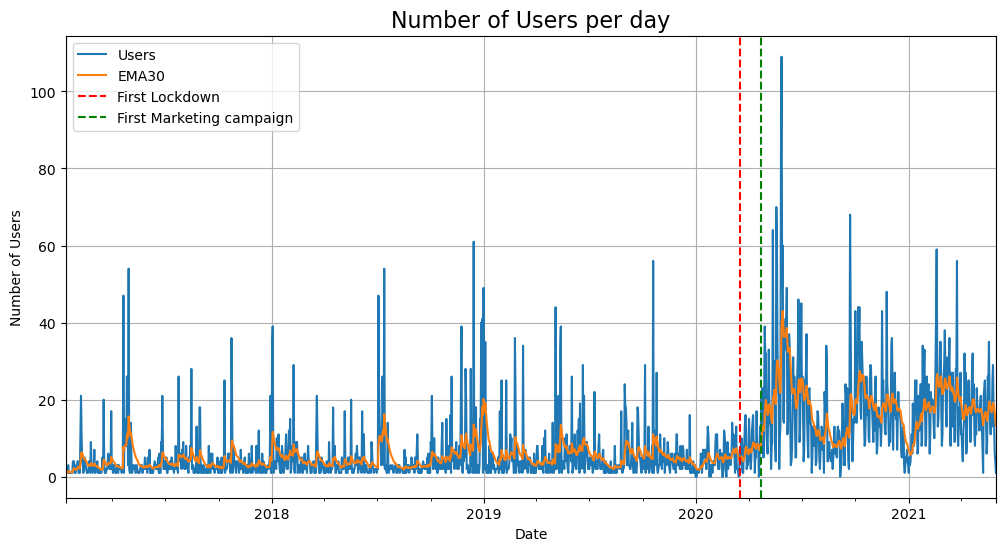

In [265]:

# Moving average for showing trend
data['EMA30'] = data['Users'].ewm(span=15).mean()

# Plot the DataFrame
ax = data[['Users', 'EMA30']].plot(label='Users', figsize=(12, 6))

# Add a vertical line at the date '2020-03-17'
ax.axvline(x='2020-03-17', color='red', linestyle='--', label='First Lockdown')
ax.axvline(x='2020-04-21', color='green', linestyle='--', label='First Marketing campaign')

# Set the labels and title
plt.title('Number of Users per day', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Number of Users')
plt.legend()
plt.grid(True)
plt.show()


Using plotly we can create an interactive dashboard showing the time series according to:  
- Frequency of data (daily,weekly,monthly,yearly) thanks to a selector   
- Period of interest thanks to a slider   

In [266]:
import plotly.express as px
import pandas as pd

fig = px.line(data,
             x=data.index,
             y=['Users', 'EMA30'],
             width=1200, height=800,
             title='Numbers of Users with period slider and frequency selectors',
             render_mode='webg1',
             color_discrete_map={'Users': 'lightblue', 'EMA30': 'orange'})

# set bacground
fig.update_layout(
    plot_bgcolor='white'
)
# add slider and selector
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    ),
    linecolor='black',
    gridcolor='lightgrey'
)

# add vertical grid
fig.update_yaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

# add covid start date 
fig.add_vline(x='2020-03-17',
              line_width=3, line_dash="dash", line_color="red",
              label=dict(
                  text="Covid start",
                  textposition="middle",
                  font=dict(size=15, color="red")))
# add marketing campaign start date
fig.add_vline(x='2020-04-21', line_width=3, line_dash="dash", line_color="green")

fig.add_vline(x="2020-04-21",
              line_width=3, line_dash="dash", line_color="green",
              label=dict(
                  text="Marketing Campaign start",
                  textposition="middle",
                  font=dict(size=15, color="green")))
fig.show()

## **2. Exploration**

### **Pre covid e post covid**

In [267]:
# Data from 2017 to covid 
data_preCOVID = data.loc[:'2020-03-17']

# Post covid
data_postCOVID = data.loc['2020-03-17':]


From the following graphs we can see the difference between pre covid (left) and post covid (right)

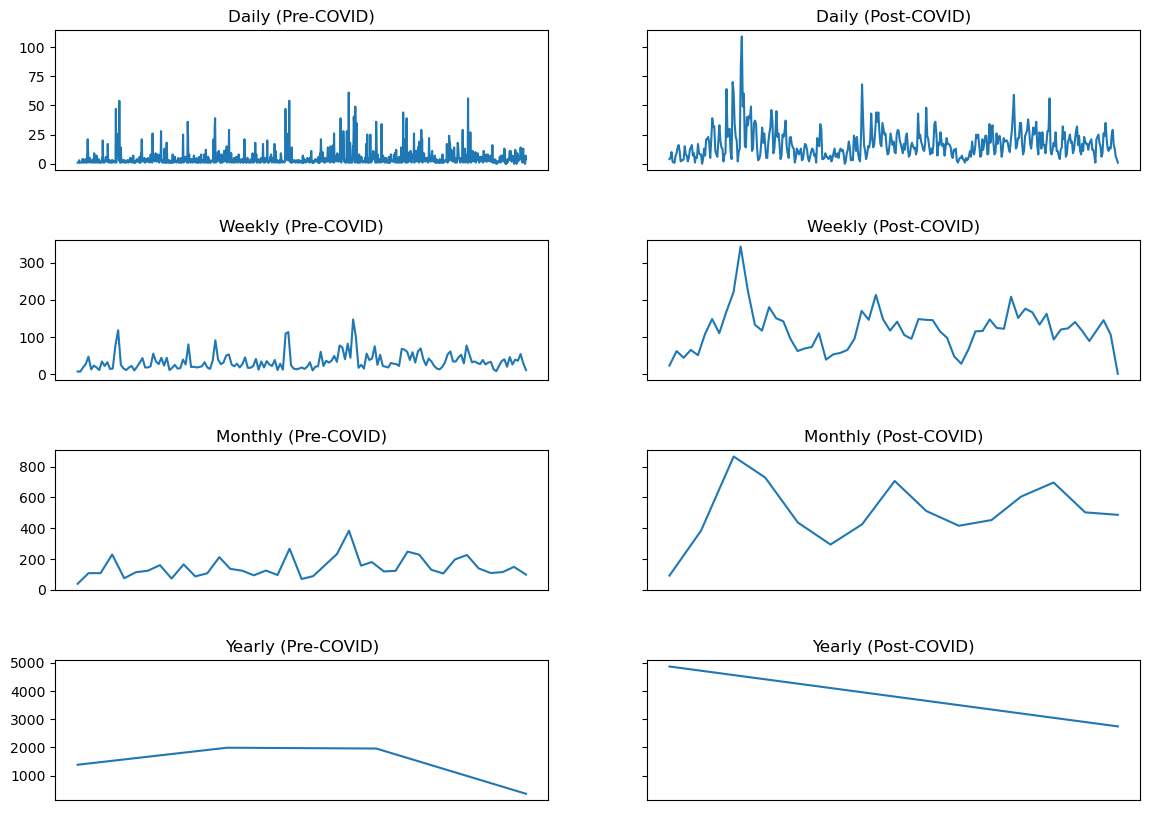

In [268]:
import matplotlib.pyplot as plt

# Creazione di figure e assi
fig, axs = plt.subplots(4, 2, figsize=(14,10), sharey='row', gridspec_kw={'hspace': 0.5, 'wspace': 0.2})
axs = axs.flatten()

# plot pre-COVID
axs[0].plot(data_preCOVID['Users'].resample('D').sum())
axs[2].plot(data_preCOVID['Users'].resample('W').sum())
axs[4].plot(data_preCOVID['Users'].resample('M').sum())
axs[6].plot(data_preCOVID['Users'].resample('Y').sum())

# plot post-COVID
axs[1].plot(data_postCOVID['Users'].resample('D').sum())
axs[3].plot(data_postCOVID['Users'].resample('W').sum())
axs[5].plot(data_postCOVID['Users'].resample('M').sum())
axs[7].plot(data_postCOVID['Users'].resample('Y').sum())

# titles pre-COVID
axs[0].set_title('Daily (Pre-COVID)')
axs[2].set_title('Weekly (Pre-COVID)')
axs[4].set_title('Monthly (Pre-COVID)')
axs[6].set_title('Yearly (Pre-COVID)')

# titles post-COVID
axs[1].set_title('Daily (Post-COVID)')
axs[3].set_title('Weekly (Post-COVID)')
axs[5].set_title('Monthly (Post-COVID)')
axs[7].set_title('Yearly (Post-COVID)')

# remove dates on x axes
for ax in axs:
    ax.set_xticklabels([])
    ax.set_xticks([])

plt.tight_layout()
plt.show()

From the plots we can see:
- Trend in the users that tend to be stronger and decreasing during the covid period (from yearly plot)
- Clear seasonality (froom weekly plot)
- No clear cycle  

After covid we can see a behaviour with:
- higer average level 
- higer variability

### **Seasonality Test**

After having added the days of the week to the excel file we can check easily check that there are difference in users across days of the week  


Average Users: 

8.307116104868914

Average users by day: 

   Monday  9
  Tuesday 11
Wednesday 10
 Thursday 10
   Friday  8
 Saturday  6
   Sunday  5


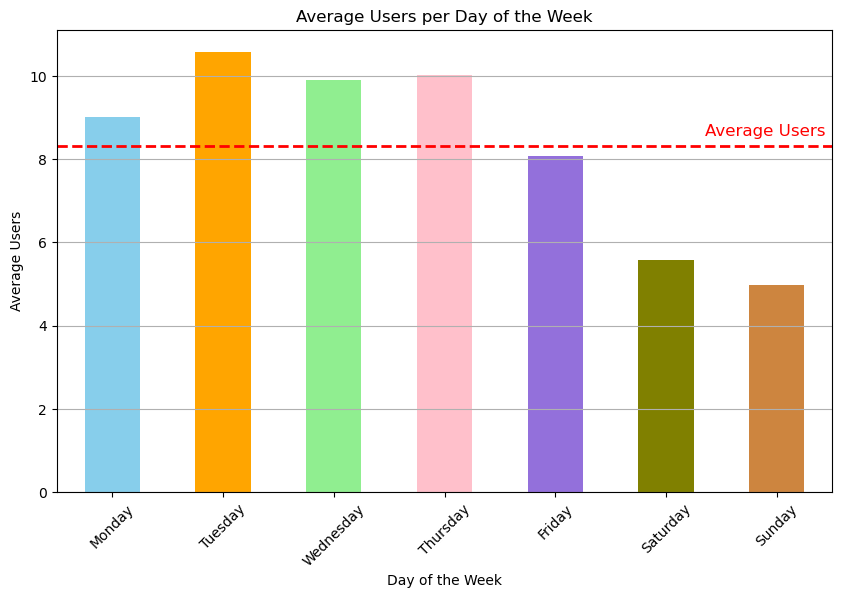

In [269]:
df = pd.DataFrame(data)

# Avarage users
average_users_by_day = df.groupby('Weekday')['Users'].mean()
average_users = df["Users"].mean()

# order weekdays
days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
average_users_by_day = average_users_by_day.reindex(days_of_week)

# print average users
print()
print(start_bold + "Average Users: "+ end_bold)
print()
print(average_users)

# print daily average users in a pretty way 
print(start_bold + "\nAverage users by day: \n" + end_bold)
average_users_dict = average_users_by_day.to_dict()
average_users_df = pd.DataFrame(list(average_users_dict.items()), columns=['Day', 'Average'])
average_users_df["Average"] = round(average_users_df["Average"],0)
average_users_df["Average"] = average_users_df["Average"].astype(int)
print(average_users_df.to_string(index=False, header=False))


# Barplot
plt.figure(figsize=(10, 6))
average_users_by_day.plot(kind='bar', color=['skyblue', 'orange', 'lightgreen', 'pink', 'mediumpurple', "olive", "peru"])
plt.axhline(average_users, color='red', linestyle='dashed', linewidth=2, label='Average Users')
plt.text(5.9 ,8.5, 'Average Users', color='red', fontsize=12, va='bottom', ha='center')
plt.title('Average Users per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Users')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Mostra il grafico
plt.show()

We can test the difference in mean across days for having a confirmation of the graph results

In [270]:

# t-test for checking if users per day significantly different from average
for day, average in average_users_by_day.items():
    t_stat, p_value = ttest_ind(data[data['Weekday'] == day]['Users'], data['Users'])
    print()
    print(f"{start_bold}T-test for {day}{end_bold}:")
    print(f"t_statistic = {round(t_stat , 2)}")
    print(f"p_value = {round(p_value, 2)}")




T-test for Monday:
t_statistic = 0.97
p_value = 0.33

T-test for Tuesday:
t_statistic = 2.97
p_value = 0.0

T-test for Wednesday:
t_statistic = 2.1
p_value = 0.04

T-test for Thursday:
t_statistic = 2.29
p_value = 0.02

T-test for Friday:
t_statistic = -0.32
p_value = 0.75

T-test for Saturday:
t_statistic = -3.76
p_value = 0.0

T-test for Sunday:
t_statistic = -4.71
p_value = 0.0


We can therefore see how the days in the middle of the week have on average more users while Saturday and Sunday have fewer.   
This proves a weekly seasonality that must be taken into account.

### **Remove trend and seasonality**

From the ACF and PACF plots we can see that the series si non stationary:
- Autocorrelation (ACF significantly positive and decreasing)  
- Seasonality (as mentioned before we see that it follows the days of the week)  

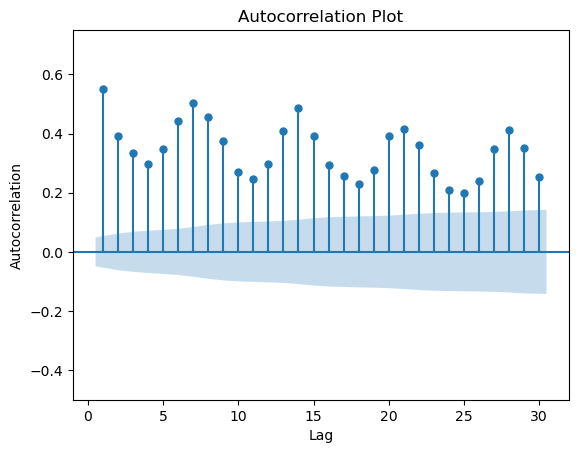

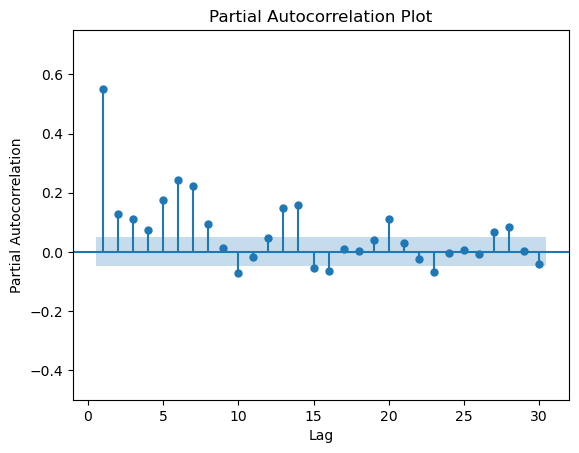

In [271]:
def plot_ACF(data):
    plot_acf(data, lags=30, zero=False) 
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title('Autocorrelation Plot')
    plt.ylim(-0.5, 0.75)  
    plt.show()

def plot_PACF(data):
    plot_pacf(data, lags=30, zero=False)  
    plt.xlabel('Lag')
    plt.ylabel('Partial Autocorrelation')
    plt.title('Partial Autocorrelation Plot')
    plt.ylim(-0.5, 0.75)  
    plt.show()



plot_ACF(data["Users"])
plot_PACF(data["Users"])

We can apply first order differentiation for making the series stationary

In [272]:
# apply first and second order difference for reducing non stationaryty 
data_d1 = data["Users"].diff().dropna()
data_d2= data["Users"].diff().diff().dropna()


Differentiating beyond the first order lead to chaotic behaviour, maybe because the trend is not well defined,   
from this graph we can see that is better tot keep the first order differentiation rather than the second that leads to unpredictable behaviour

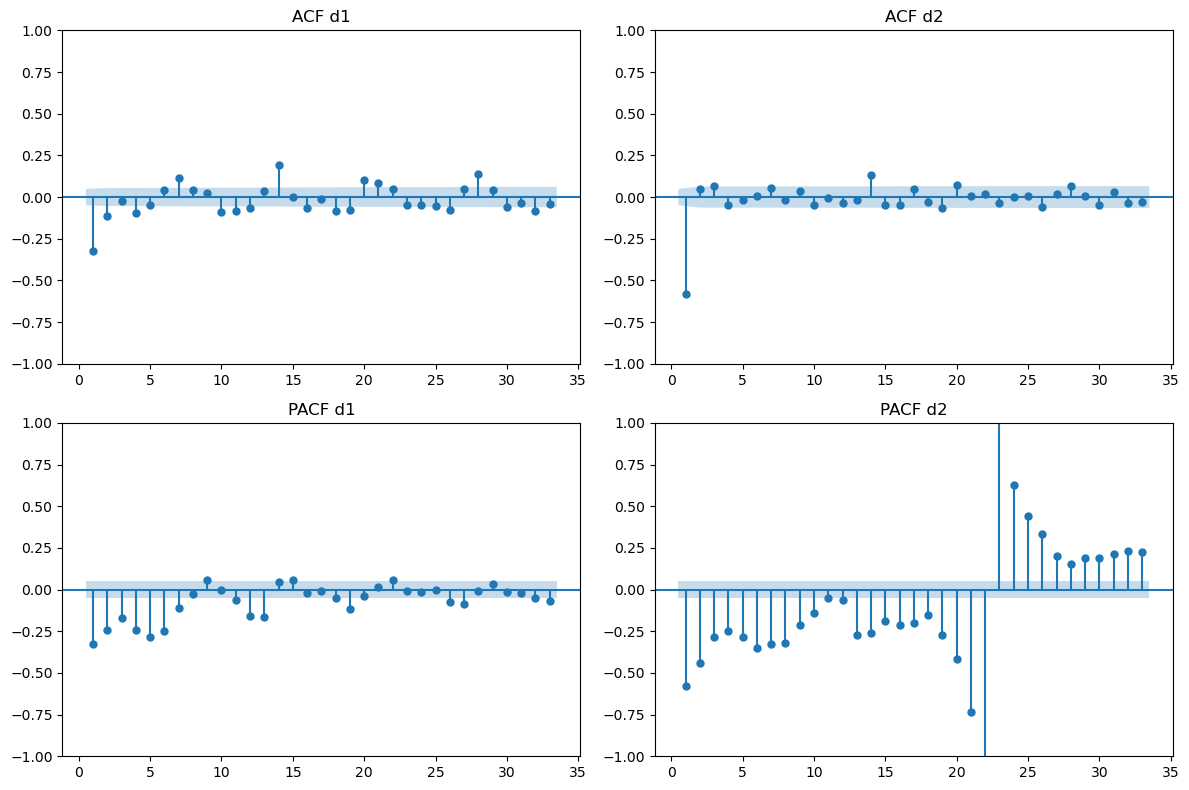

In [273]:
# Plot ACF for difference 1 order 
fig, ax = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

# Plot ACF for difference 1 order 
plot_acf(data_d1, ax=ax[0, 0], zero=False)
ax[0, 0].set_title('ACF d1')

# Plot ACF for difference 2 order 
plot_acf(data_d2, ax=ax[0, 1], zero=False)
ax[0, 1].set_title('ACF d2')

# Plot PACF for difference 1 order 
plot_pacf(data_d1, ax=ax[1, 0], zero=False)
ax[1, 0].set_title('PACF d1')

# Plot PACF for difference 2 order 
plot_pacf(data_d2, ax=ax[1, 1], zero=False)
ax[1, 1].set_title('PACF d2')

plt.tight_layout()
plt.show()


We can try seasonal differencing for stabilizing the data.  
For doing so we can try recursively different seasonality periods for 1 to 7 to check what is the best

Seasonality of period 1 days


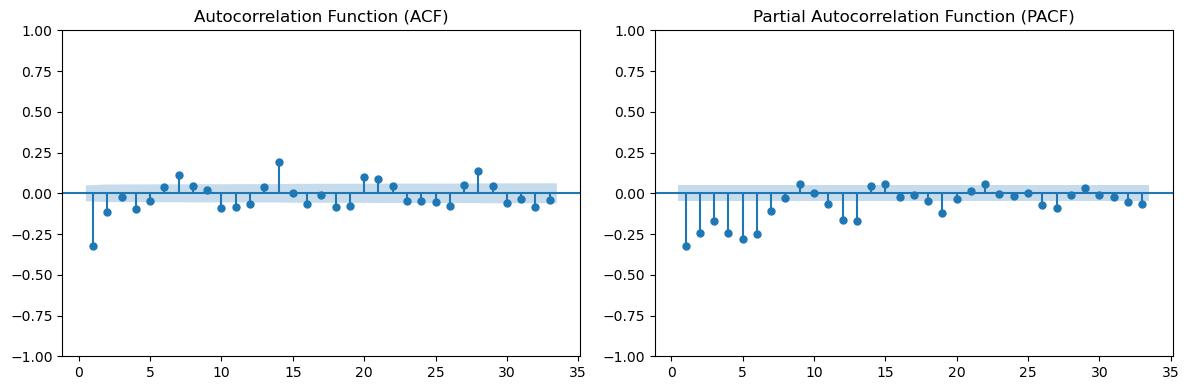

Seasonality of period 2 days


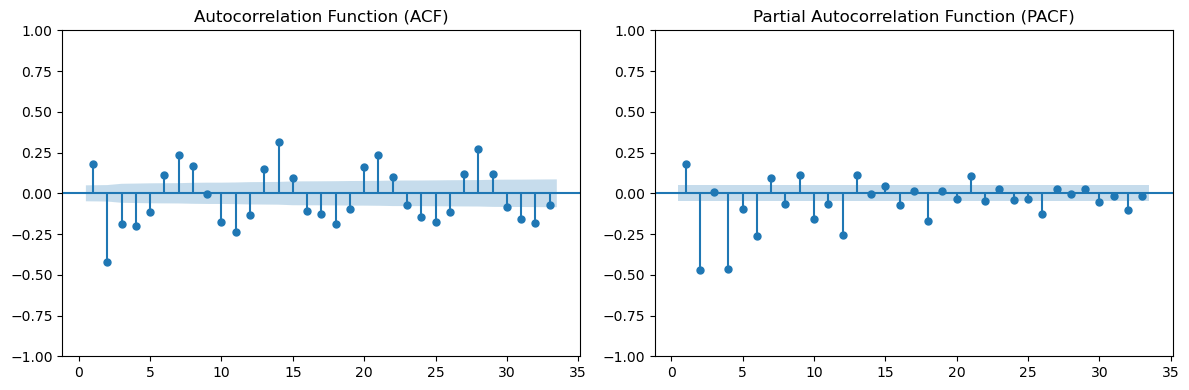

Seasonality of period 3 days


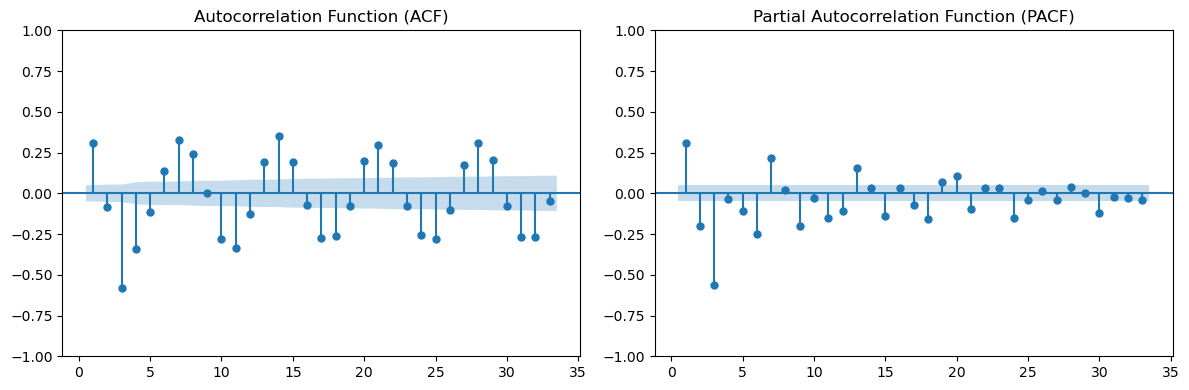

Seasonality of period 4 days


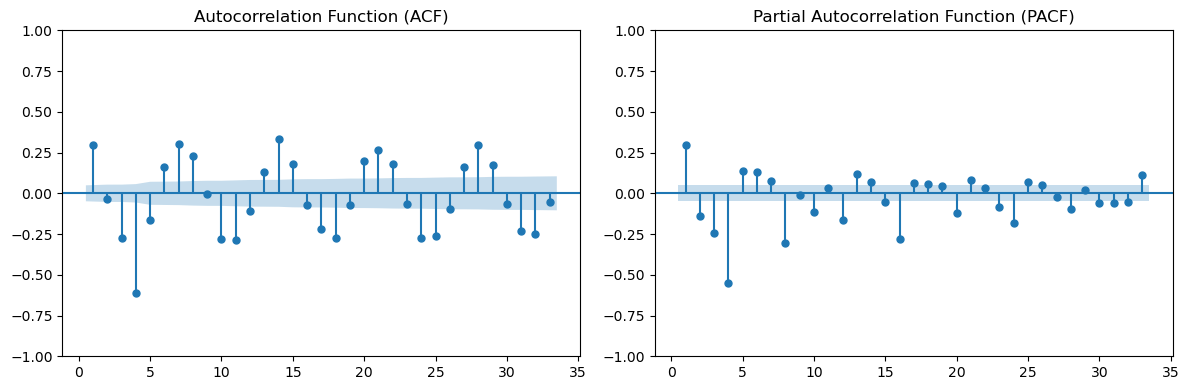

Seasonality of period 5 days


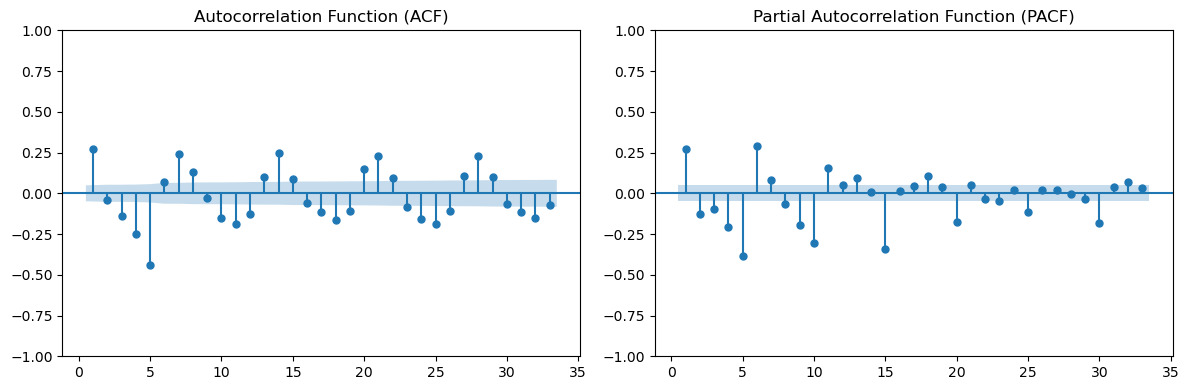

Seasonality of period 6 days


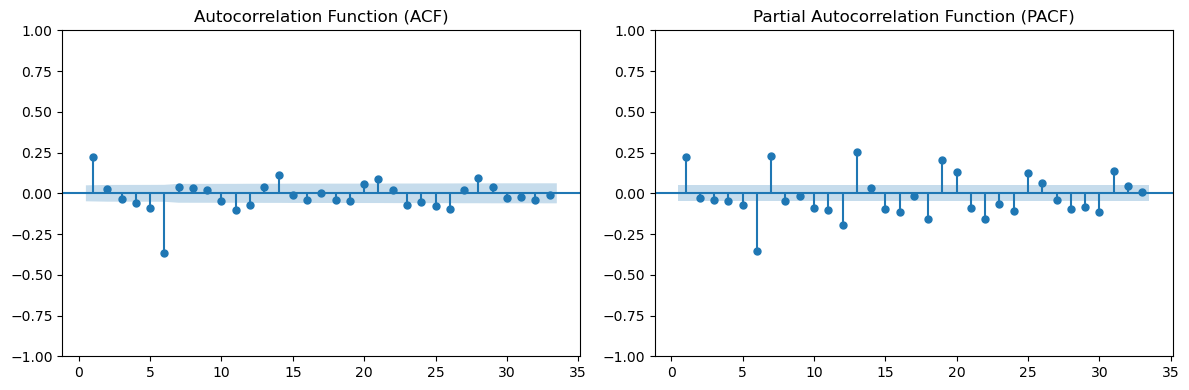

Seasonality of period 7 days


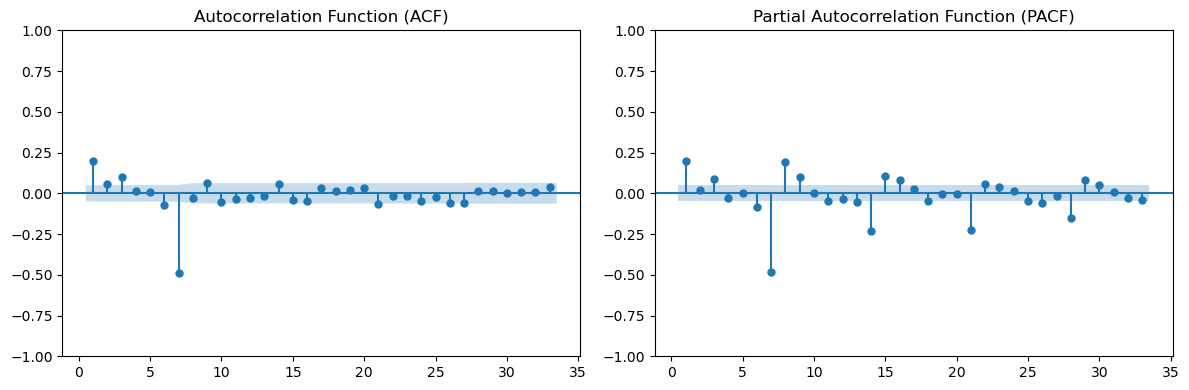

In [274]:
for d in range(1,8):

    # seasoonal differencing 
    data_ds= data["Users"].diff(periods = d).dropna()

    # plot acf e pacf
    print(f"{start_bold}Seasonality of period {d} days{end_bold}")
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns
    plot_acf(data_ds, ax=ax[0], zero=False)
    ax[0].set_title('Autocorrelation Function (ACF)')
    plot_pacf(data_ds, ax=ax[1], zero=False)
    ax[1].set_title('Partial Autocorrelation Function (PACF)')
    plt.tight_layout()
    plt.show()

Just differencing does not make the series stationary.   
We do not indagate further given the fact that we will try different models that will deal with non stationarity in different ways,  
 keeping in mind to look at residuals for finding unexxploited patterns related to autocorrelations and non stationariety

## **3. MODELLING**

### **Train test split**

The last date in our data is 2021-05-31 and we need to predict till 31-12-2022 (580 days to predict).  

To give us an idea of ​​how many days we have in our dataset versus how many days we have to predict for the forecast we can     
compute the he ratio of days to predictover the days available in our dataset, that is:    

In [275]:
days_to_predict = 580

days_in_dataset = len(data)

print("Days to predict / Days available: ", (days_to_predict / days_in_dataset)*100, "%")

Days to predict / Days available:  36.20474406991261 %


In order to have:  
- An adequate training set 
- An adequate test set given the non neglectable lenght of the forecast 

We can split 80% training and 20% testing, in this way the splitting date would be the 2020-07-15

This decision is not accidental.   
The time series changes in the last period after Covid & Commercial campaigns. We are not interested in prooving that there is a causal relation   
here but we have to acknoledge the time series behavour and splitting the data in this way we can include information from the covid-commercial campaign period in the models   
(We know that this behaviour could be consistent across 2022 as well)



In [276]:
# split the data
training_data = data.loc[:'2020-07-15', 'Users']
test_data = data.loc['2020-07-15':, 'Users']

### **Model performance measures**

The time series an take also values ​​0 so we cannot use methods such as MAPE or W-MAPE.  

Considering:
- y_true: true value
- y_pred: predicted value
- n: lenght of test data

For our purposes the two useful (complementary) measures we will use are:

- **MSE** (Mean square error):  

$$ \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_{\text{true},i} - y_{\text{pred},i})^2 $$



- **RMSE** (Mean square error):  

$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_{\text{true},i} - y_{\text{pred},i})^2}
$$


We will use both of them because:
- MSE penalizes large errors and is computationally easy (error variance)
- RMSE is more interpretable because it gives values in the unit of measures of our variable (difference on average between actual number of users and model forecasted number of users)
- Strong Differences in MSE e RMSE con tell us if there are sporadic but strong errors rather than more uniform ones   

   



In [277]:
# Plot model performance 

def plot_model(training_data,test_data, model_fit, forecast):
    plt.figure(figsize=(10, 6))
    # plot training data
    plt.plot(training_data, label='Training Data')
    # plot fitted data
    plt.plot(model_fit.fittedvalues)
    # plot test data
    plt.plot(test_data, label='Test Data')
    # plot forecasted data in test data
    plt.plot(test_data.index, forecast, label='Forecast')
    plt.xlabel('Time')
    plt.ylabel('Number of Users')
    plt.legend()
    plt.show()


# plot model test 
def plot_model_test(test_data, forecast):
    plt.figure(figsize=(10, 6))
    # plot test data
    plt.plot(test_data, label='Test Data')
    # plot forecasted data in test data
    plt.plot(test_data.index, forecast, label='Forecast')
    plt.xlabel('Time')
    plt.ylabel('Number of Users')
    plt.legend()
    plt.show()

# KPI model performance  MSE and RMSE

def measure_model(Y_actual, Y_predicted):

    # compute MSE
    mse = np.mean((Y_actual - Y_predicted) ** 2)

    # compute RMSE
    rmse = np.sqrt(mse)

    # difference
    diff = mse - rmse
    
    # table
    data = {
        'Metrics': ['MSE', 'RMSE', 'difference (MSE - RMSE)'],
        'Value': [mse, rmse, diff]
    }
    df = pd.DataFrame(data)
    
    # do not show index
    df.index = pd.Index([''] * len(df))
    return df

### **Average model**

The average model will just use the average number of users in training samples for predicing the whole test set.

We will use the average model and the seasonal average model for **benchmark of our more sofisticated models**.

In [278]:
# average users in training sample 
mean_training = np.mean(training_data)

# make the forecast simpling putting the mean
forecast_mean = pd.DataFrame(index= test_data.index)
forecast_mean["Users"] = mean_training

# model performance
measure_model(test_data, forecast_mean["Users"])

,Metrics,Value
,MSE,208.507927
,RMSE,14.439804
,difference (MSE - RMSE),194.068123


### **Seasonal Average model**

The Seasonal average model is an improvement of the average model.
Instead of predicting just the training set mean for the test data it will predict each test data day using the average number of users of that day in the training set.  
For instance if the model has to predict tomorrow that is a friday it will use the average number of users of all the firdays in the training set

In [279]:
# split the data
trd = data.loc[:'2020-07-15']
tsd = data.loc['2020-07-15':]

# add daily average to trianing data 
trd['daily avg'] = df.groupby('Weekday')['Users'].transform('mean')

# training and test set starts from the same day so we can just cut it 
daily_avg = list(trd['daily avg'])[:len(tsd)]

# add daily average to test data, this will be the forecast
tsd["daily avg"] = daily_avg

tsd.head(3)

,Users,Lockdown_flag,Campaigns_flag,Weekday,EMA30,daily avg
Date,,,,,,
2020-07-15,17,0,0,Wednesday,19.390991,9.895197
2020-07-16,14,0,0,Thursday,18.717117,10.030568
2020-07-17,13,0,0,Friday,18.002477,8.069869


In [280]:
# average users in training sample 
mean_training = np.mean(training_data)

# make the forecast simpling putting the mean
forecast_mean = pd.DataFrame(index= test_data.index)
forecast_mean["Users"] = mean_training

# model performance
measure_model(test_data, tsd["daily avg"])

,Metrics,Value
,MSE,153.742044
,RMSE,12.399276
,difference (MSE - RMSE),141.342768


The model perform better despite its simplicity due to strong week seasonality, we will see that in this type of data improving a simple model like this is no joke.

### **Arima model**

The first model we are going to test is ARIMA, trying as parameters:  
- p = 2 orders of autoregressive components  
- d = 1 so apply one differentiation to make data more stationary   
- q = 2 orders of Moving averages components  

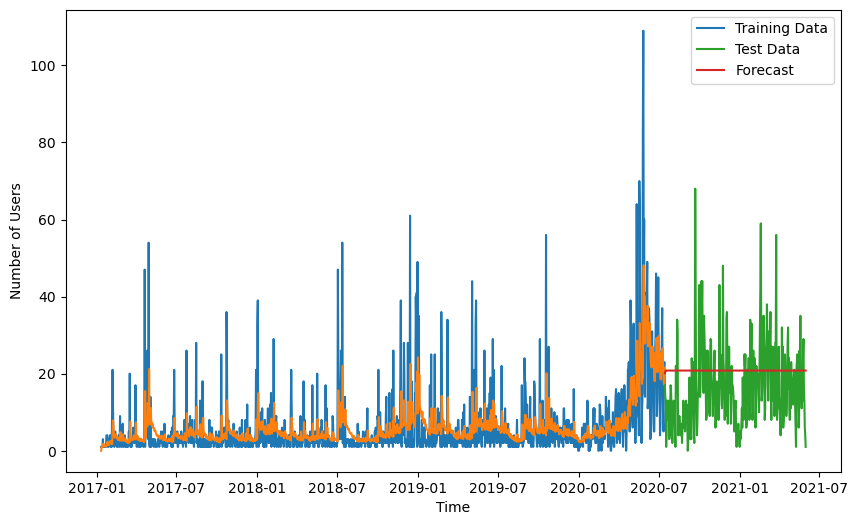

,Metrics,Value
,MSE,125.145351
,RMSE,11.186838
,difference (MSE - RMSE),113.958513


In [281]:

# ARIMA model parameters (p, d, q)
p = 2 
d = 1 # Differencing order 1 to make the data Stationary
q = 2  

# Create and fit ARIMA model on training data
model = ARIMA(training_data, order=(p, d, q))
model_fit = model.fit()

# Forecasting on test data
forecast_steps = len(test_data)
forecast_ARIMA = model_fit.forecast(steps=forecast_steps)

plot_model(training_data,test_data, model_fit, forecast_ARIMA)

measure_model(test_data,forecast_ARIMA)

The model just predict a straight line, we can see that it has correctly transposed the rise in the mean of the post covid data but fails to predict fluctuations.   
This could be because it does not consider seasonality, so we can try the **SARIMA** model that takes into acocunt weekly seasonality (m = 7).

SARIMA mdoel takes this parameters

1. Autoregressive components: 
    - Autoregressive (AR) Component: relationship between the current observation and a certain number of lagged observations
    - Seasonal Autoregressive (SAR) Component: relationship between the current observation and a certain number of lagged observations at seasonal intervals.

2. Differencing:

    - Non-Seasonal Differencing Component: 
    - Seasonal Differencing Component:

3. Moving Average components:
    - Moving Average (MA) Component: relationship between the current observation and the residual errors from a moving average model appliеd to lagged observations.
    - Seasonal Moving Average (SMA) Component: relationship between the current observation and the residual errors from a moving average model applied to lagged observations at seasonal intervals.

4. Error Term: 
    - It represents unexplained variation in the time series



For finding the best parameters quickly we use the **auto arima**

In [284]:

model = auto_arima(training_data,
                   seasonal=True,                   
                   
                   # weekly sesasonality
                   m=7,                    
                   
                   # first order differencing for tending to stationarity
                   d=1,           
                   
                   # starting parameters p q of non seasonal compontents
                   start_p=0,
                   start_q=0,
                   # max paraemters p e q of non seasonal components
                   max_p=2,  
                   max_q=2,
                   
                   # starting parameters PDQ of seasonal compontents
                   start_P=0, 
                   start_D=0, 
                   start_Q=0,

                   # max parameters PDQ of seasonal compontents
                   max_P=2, 
                   max_D=2, 
                   max_Q=2,
                   
                   max_order=10,
                   stepwise=True,  
                   suppress_warnings=True,  
                   error_action="ignore",  
                   trace=True)  




Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=9532.125, Time=0.18 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=9323.875, Time=1.47 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=9020.532, Time=1.89 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=9530.127, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=9037.108, Time=0.91 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=8955.673, Time=5.69 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=9014.390, Time=1.67 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=8955.649, Time=9.64 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=8984.216, Time=3.49 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=inf, Time=14.75 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=8955.805, Time=10.72 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=9493.978, Time=4.18 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=8924.515, Time=12.31 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=8923.942, Time=8.08 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept  

The best model is automatically called "model" and of course is already fitted, so we can just make the preidction with it 

In [285]:
# predict using the best auto SARIMA model
forecast_SARIMA_auto = model.predict(len(training_data))

# measure model performance 
measure_model(test_data, forecast_SARIMA_auto)



,Metrics,Value
,MSE,157.916057
,RMSE,12.566466
,difference (MSE - RMSE),145.349591


The models still perform poorly, on average there is an error of 12-13 users that is too big considering our usual values.    
We can therefore try to change approach 

### **Exogenous Regression Approach** 

We can try a more "Econometrical approach" building a model that try to predict the users given the dummy variables:  
- Lockdown flag and Campaign flag: presence or absence of lockdown / marketing campaign  
- Encoded day of the week for considering seasonality and day effect 

In [286]:
# encoding days of the week
data_enc = data

data_enc['Monday'] = (data['Weekday'] == 'Lunedì').astype(int)
data_enc['Tuesday'] = (data['Weekday'] == 'Martedì').astype(int)
data_enc['Wednesday'] = (data['Weekday'] == 'Mercoledì').astype(int)
data_enc['Thursday'] = (data['Weekday'] == 'Giovedì').astype(int)
data_enc['Friday'] = (data['Weekday'] == 'Venerdì').astype(int)
data_enc['Saturday'] = (data['Weekday'] == 'Sabato').astype(int)
data_enc['Sunday'] = (data['Weekday'] == 'Domenica').astype(int)


# split into training and test
training_data_enc = data_enc.loc[:'2020-07-15']

test_data_enc = data_enc.loc["2020-07-15":]


# split into exogenous X and endogenous Y variables the training and test
# note: monday is not considered for avoiding perfect collinearity 

X_training = training_data_enc[["Lockdown_flag","Campaigns_flag","Tuesday",  "Wednesday",  "Thursday",  "Friday",  "Saturday", "Sunday"]]  # Variables: Covid, Market, Campaign, Weekday
Y_training = training_data_enc['Users']


X_test = test_data_enc[["Lockdown_flag","Campaigns_flag","Tuesday",  "Wednesday",  "Thursday",  "Friday",  "Saturday", "Sunday"]]  # Variables: Covid, Market, Campaign, Weekday
Y_test = test_data_enc['Users']

# add constant 
X_training = sm.add_constant(X_training)
X_test = sm.add_constant(X_test)


# make regression
model = sm.OLS(Y_training, X_training).fit()

Y_pred = model.predict(X_test)

model.summary()

measure_model(Y_test,Y_pred)

,Metrics,Value
,MSE,212.404354
,RMSE,14.574099
,difference (MSE - RMSE),197.830255


Model performance is lower that the auto Sarima

### **Exogenous Arima approach**

We can merge the ARIMA with the exogenous  regressors approach building an Exogenous ARIMA model.

This model will use the exogenous regressors:
- Lockdown_flag
- Campaigns_flag

modelling the error as an ARIMA process
- AR: autoregressive part, we keep the best Sarima parameter
- D: differencing order, we keep 1 
- MA: moving average part, we keep the best Sarima parameter


                               SARIMAX Results                                
Dep. Variable:                  Users   No. Observations:                 1282
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -4577.648
Date:                Wed, 05 Jun 2024   AIC                           9165.295
Time:                        11:13:59   BIC                           9191.072
Sample:                    01-11-2017   HQIC                          9174.974
                         - 07-15-2020                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Lockdown_flag    -23.5276      1.745    -13.482      0.000     -26.948     -20.107
Campaigns_flag    20.8337      1.116     18.673      0.000      18.647      23.021
ar.L1             -0.5128      0.014

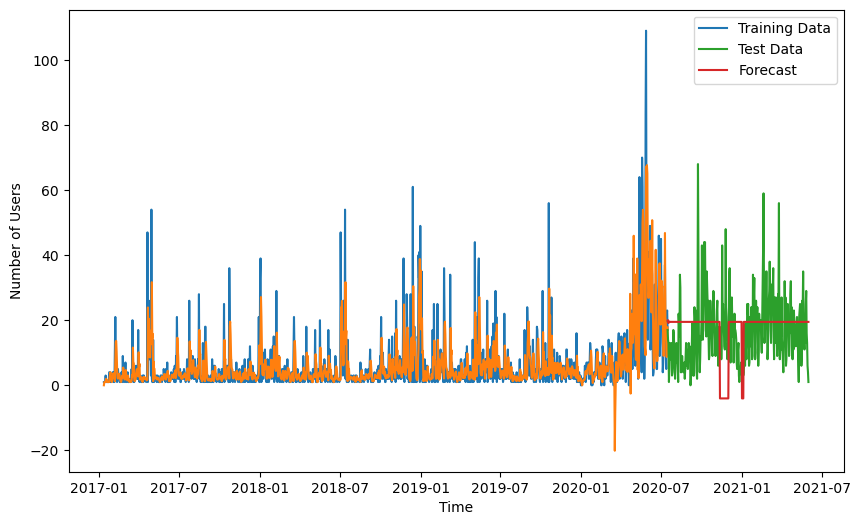

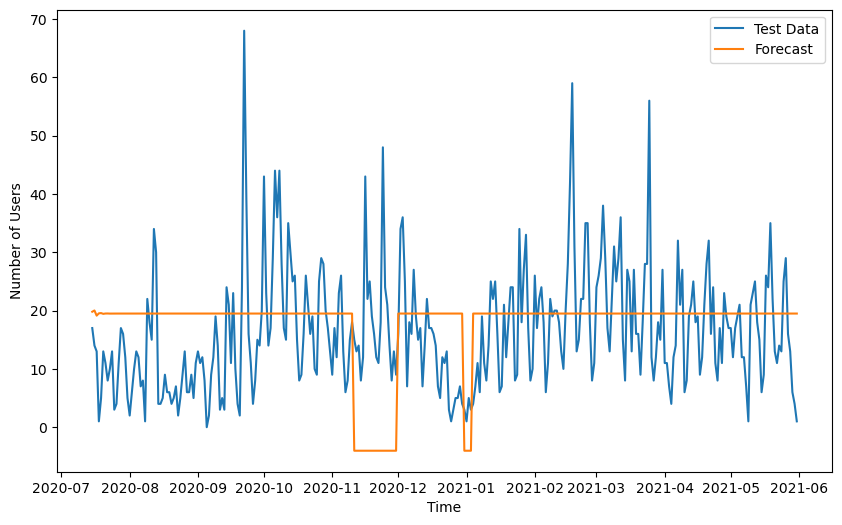

,Metrics,Value
,MSE,143.850066
,RMSE,11.993751
,difference (MSE - RMSE),131.856315


In [287]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA


# split into exogenous X and endogenous Y variables the training and test
# note: monday is not considered for avoiding perfect collinearity 

X_training = training_data_enc[["Lockdown_flag","Campaigns_flag"]]  # Variables: Covid, Market, Campaign
Y_training = training_data_enc['Users']


X_test = test_data_enc[["Lockdown_flag","Campaigns_flag"]]  # Variables: Covid, Market, Campaign, Weekday
Y_test = test_data_enc['Users']


# ARIMA with regressors that are exogenous
model = sm.tsa.ARIMA(Y_training, exog=X_training, order=(2,1,0))  # Ordine ARIMA: AR(1,1,0)
model_fit= model.fit()


forecast_steps = len(test_data_enc)
forecast_reg = model_fit.forecast(steps=forecast_steps, exog= X_test)


print(model_fit.summary())
plot_model(training_data_enc["Users"], test_data_enc["Users"], model_fit ,forecast_reg)
plot_model_test(test_data_enc["Users"],forecast_reg)
measure_model(test_data_enc["Users"], forecast_reg )

We can improve the model using the Sarima approach that will consider seasonality

### **Exogenous Sarima approach**

Autoregressive components: 
- Autoregressive (AR) Component: relationship between the current observation and a certain number of lagged observations
- Seasonal Autoregressive (SAR) Component: relationship between the current observation and a certain number of lagged observations at seasonal intervals.

Differencing:

- Non-Seasonal Differencing Component: 
- Seasonal Differencing Component:

Moving Average components:
- Moving Average (MA) Component: relationship between the current observation and the residual errors from a moving average model appliеd to lagged observations.
- Seasonal Moving Average (SMA) Component: relationship between the current observation and the residual errors from a moving average model applied to lagged observations at seasonal intervals.

Exogenous regressors:
- Lockdown_flag
- Campaigns_flag

Error Term: It represents unexplained variation in the time series

                                     SARIMAX Results                                     
Dep. Variable:                             Users   No. Observations:                 1282
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -4425.068
Date:                           Wed, 05 Jun 2024   AIC                           8864.136
Time:                                   11:14:18   BIC                           8900.185
Sample:                               01-11-2017   HQIC                          8877.675
                                    - 07-15-2020                                         
Covariance Type:                             opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Lockdown_flag     -9.8837      1.079     -9.162      0.000     -11.998      -7.769
Campaigns_flag    13.7479      

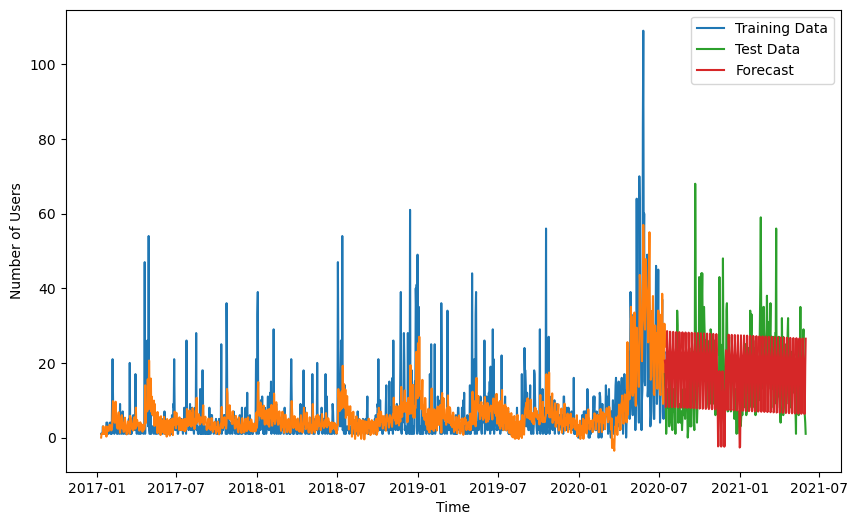

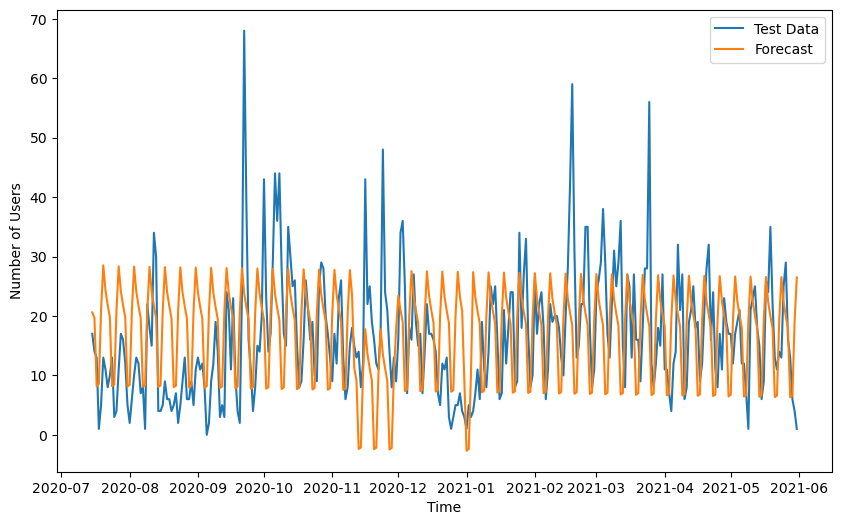

,Metrics,Value
,MSE,92.282516
,RMSE,9.606379
,difference (MSE - RMSE),82.676137


In [288]:
# define seasonal order parameters
seasonal_order = (1, 1, 1, 7)  # ad esempio, P=1, D=1, Q=1, s=7

# Creare il modello SARIMA
model = SARIMAX(Y_training, exog=X_training, order=(1, 1, 1), seasonal_order=seasonal_order)
model_fit = model.fit()

# Fare previsioni sui dati di test
Y_pred = model_fit.predict(start=len(Y_training), end=len(Y_training) + len(Y_test) - 1, exog=X_test)


print(model_fit.summary())
plot_model(training_data, test_data, model_fit ,Y_pred)
plot_model_test(test_data,Y_pred)
measure_model(test_data, Y_pred )

### **Exponential smoothing (HOLT WINTERS)**

It is necessary to keep in mind that exponential smoothing does not have within it a method to differentiate like the ARIMA model.   
It is therefore necessary to differentiate first, as we have seen we use difference first (I have already tried exponenthial smoothing without differentiation because it performs much worse)

In [289]:
training_data_d1 = data_d1.loc[:'2020-07-15']
test_data_d1 = data_d1.loc['2020-07-15':]

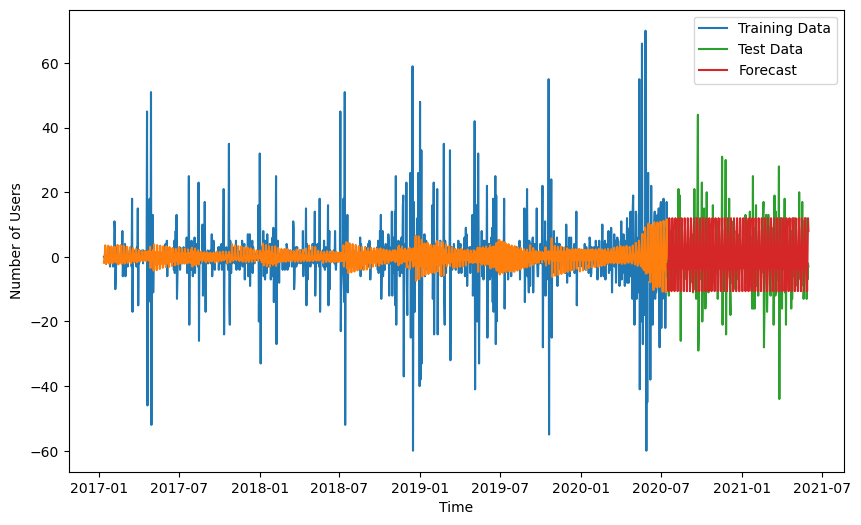

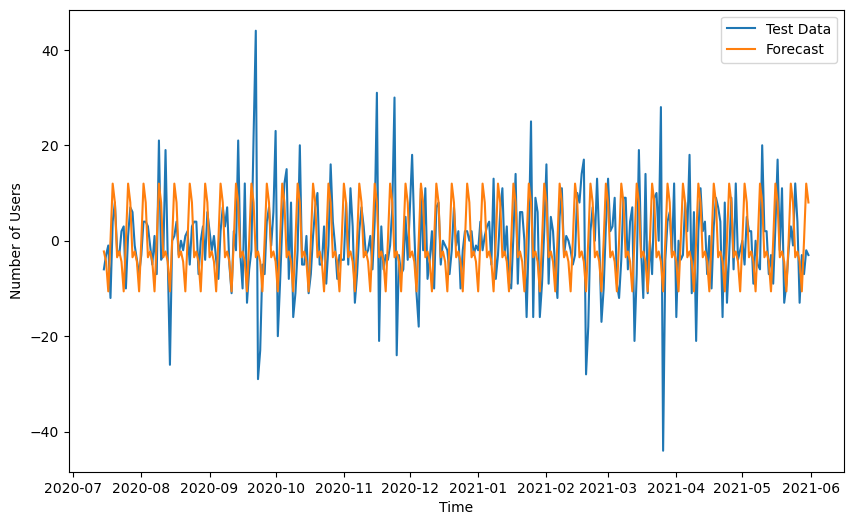

,Metrics,Value
,MSE,83.024592
,RMSE,9.111783
,difference (MSE - RMSE),73.912809


In [290]:

HW1 = ExponentialSmoothing(training_data_d1,
                            trend=None,
                            damped_trend=False, # for curving trend forecast
                            seasonal= "add",
                            seasonal_periods= 7,
                            initialization_method='estimated',
                            initial_level=None, 
                            initial_trend=None, 
                            initial_seasonal=None, 
                            use_boxcox=False, 
                            bounds=None, 
                            dates=None, 
                            freq= "D", 
                            missing='none')


HW1_fit = HW1.fit()

# make the forecast for exponential smoothing 
forecast_steps = len(test_data)

forecast = HW1_fit.forecast(steps=forecast_steps)

plot_model(training_data_d1, test_data_d1, HW1_fit ,forecast)
plot_model_test(test_data_d1,forecast )
measure_model(test_data_d1, forecast  )

Interpreting the RMSE we can say that on average the model predictions tend to deviate by 9 users with respect to the true number.  
Checking the error distribution we see no room for improvement.

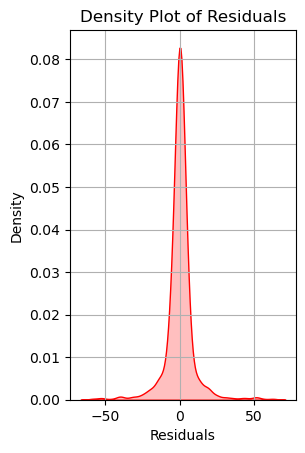

In [291]:
import seaborn as sns
# Plot della densità dei residui
plt.subplot(1, 2, 2)
sns.kdeplot(HW1_fit.resid, color='red', shade=True)
plt.title('Density Plot of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.grid(True)

## **Conclusions**

The conclusion was that the best model turned out to be **exponential smoothing**, which will have to be towed over the entire dataset in order to use it to make the 2022 forecast.

Its suboptimal performance is mainly due to the high number of 0s in the time series, which notoriously make statistical predictions complex.

